In [107]:
# Import dependencies
import pandas as pd
import numpy as np
import math
from statistics import mean
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [2]:
# Read data
presnap_data_oline_all = pd.read_csv('https://storage.googleapis.com/big-data-bowl/presnap-data-oline-all.csv')
presnap_data_oline_encoded = pd.read_csv('https://storage.googleapis.com/big-data-bowl/presnap-data-oline-encoded.csv')

red_zone_line_player_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneLinePlayerProximity.csv')
red_zone_qb_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneQBProximity.csv')
players = pd.read_csv('https://storage.googleapis.com/big-data-bowl/players.csv')

week1 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week1.csv')
week2 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week2.csv')
week3 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week3.csv')
week4 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week4.csv')
week5 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week5.csv')
week6 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week6.csv')
week7 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week7.csv')
week8 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week8.csv')

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Clean and concatenate week data
week1['week'] = 1
week2['week'] = 2
week3['week'] = 3
week4['week'] = 4
week5['week'] = 5
week6['week'] = 6
week7['week'] = 7
week8['week'] = 8

tracking = week1.append([
    week2,
    week3,
    week4,
    week5,
    week6,
    week7,
    week8,
])

In [4]:
# Define matchup threshold
matchup_distance_threshold = 1
matchup_duration_threshold = 20

In [5]:
# Get unique matchups that fall below threshold for frames exceeding the matchup duration_threshold
red_zone_line_player_matchups = red_zone_line_player_proximity[red_zone_line_player_proximity['distance'] <= matchup_distance_threshold]
unique_matchups = red_zone_line_player_matchups[['gameId', 'playId', 'nflId', 'nflId2', 'frameId']].groupby(['gameId', 'playId', 'nflId', 'nflId2']).min().reset_index()

In [6]:
# Initialize confirmed matchups DataFrame
confirmed_matchups = pd.DataFrame()

In [7]:
# Add matchups that last for more frames than matchup_duration_threshold to confirmed matchups DataFrame
for i, r in unique_matchups.iterrows():
    matchup = True
    matchups = pd.DataFrame()
    for f in range(matchup_duration_threshold):
        matchup_frame = red_zone_line_player_matchups[
            (red_zone_line_player_matchups['gameId'] == r['gameId']) & \
            (red_zone_line_player_matchups['playId'] == r['playId']) & \
            (red_zone_line_player_matchups['nflId'] == r['nflId']) & \
            (red_zone_line_player_matchups['nflId2'] == r['nflId2']) & \
            (red_zone_line_player_matchups['frameId'] == r['frameId'] + f)
        ]
        if len(matchup_frame) == 0:
            matchup = False
            break
        matchups = matchups.append(matchup_frame)
    if matchup:
        confirmed_matchups = confirmed_matchups.append(matchups)
confirmed_matchups

,gameId,playId,frameId,nflId,officialPosition,nflId2,officialPosition2,distance,angle
8788,2021090900,1078,16,42560.0,DT,52554.0,C,0.952733,290.907980
8832,2021090900,1078,17,42560.0,DT,52554.0,C,0.872067,296.565051
8876,2021090900,1078,18,42560.0,DT,52554.0,C,0.790759,302.082187
8920,2021090900,1078,19,42560.0,DT,52554.0,C,0.712180,308.157227
8964,2021090900,1078,20,42560.0,DT,52554.0,C,0.686804,317.950779
...,...,...,...,...,...,...,...,...,...
1396747,2021110100,4433,39,52585.0,DE,37090.0,T,0.801561,326.706437
1396791,2021110100,4433,40,52585.0,DE,37090.0,T,0.830963,320.370995
1396835,2021110100,4433,41,52585.0,DE,37090.0,T,0.834386,315.000000
1396879,2021110100,4433,42,52585.0,DE,37090.0,T,0.845044,309.718759


In [8]:
# Get next frame position and average matchup coords
next_frame = confirmed_matchups[['gameId', 'playId', 'frameId', 'nflId', 'nflId2']]
next_frame['frameIdNext'] = next_frame['frameId'] + 1
next_frame_data = next_frame.merge(tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']])
next_frame_data = next_frame_data.merge(
    tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']],
    left_on=['gameId', 'playId', 'frameIdNext', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId'],
    suffixes=('', '_opp')
)
next_frame_data['x_start'] = next_frame_data.apply(lambda r: mean([r['x'], r['x_opp']]), axis=1)
next_frame_data['y_start'] = next_frame_data.apply(lambda r: mean([r['y'], r['y_opp']]), axis=1)
next_frame_data.drop(['frameId_opp', 'x_opp', 'y_opp', 'x', 'y'], axis=1, inplace=True)

next_frame_data = next_frame_data.merge(
    tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']],
    left_on=['gameId', 'playId', 'frameIdNext', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId'],
    suffixes=('', '_next')
)

next_frame_data = next_frame_data.merge(
    tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']],
    left_on=['gameId', 'playId', 'frameIdNext', 'nflId2'],
    right_on=['gameId', 'playId', 'frameId', 'nflId'],
    suffixes=('', '_opp')
)

next_frame_data['x_end'] = next_frame_data.apply(lambda r: mean([r['x'], r['x_opp']]), axis=1)
next_frame_data['y_end'] = next_frame_data.apply(lambda r: mean([r['y'], r['y_opp']]), axis=1)

next_frame_data.drop(['frameId_opp', 'frameId_next', 'nflId_opp', 'x_opp', 'y_opp', 'x', 'y', 'nflId2'], axis=1, inplace=True)
next_frame_data

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,gameId,playId,frameId,nflId,frameIdNext,x_start,y_start,x_end,y_end
0,2021090900,1078,16,42560.0,17,15.575,29.525,15.040,29.685
1,2021090900,1078,17,42560.0,18,15.290,29.455,14.815,29.630
2,2021090900,1078,18,42560.0,19,15.020,29.385,14.610,29.570
3,2021090900,1078,19,42560.0,20,14.755,29.305,14.390,29.515
4,2021090900,1078,20,42560.0,21,14.490,29.215,14.165,29.450
...,...,...,...,...,...,...,...,...,...
20709,2021110100,4433,39,52585.0,40,21.170,21.305,20.955,21.710
20710,2021110100,4433,40,52585.0,41,21.275,21.470,21.035,21.845
20711,2021110100,4433,41,52585.0,42,21.400,21.635,21.145,21.990
20712,2021110100,4433,42,52585.0,43,21.550,21.805,21.275,22.135


In [9]:
def extract_angle(x_diff, y_diff):
    try:
        if x_diff > 0:
            if y_diff > 0:
                return 90 - math.degrees(math.atan(y_diff / x_diff))
            else:
                return 90 + math.degrees(math.atan(-y_diff / x_diff))
        else:
            if y_diff > 0:
                return 270 + math.degrees(math.atan(-y_diff / x_diff))
            else:
                return 270 - math.degrees(math.atan(y_diff / x_diff))
    except Exception as e:
        print(e)
        if y_diff > 0:
            return 0
        else:
            return 180

In [10]:
# Calculate angle of movement
next_frame_data['movement_angle'] = next_frame_data.apply(lambda r: extract_angle((r['x_end'] - r['x_start']), (r['y_end'] - r['y_start'])), axis=1)

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == "":


In [11]:
# Extract distance metric
next_frame_data['distance'] = next_frame_data.apply(
        lambda row : math.sqrt(((row['x_start'] - row['x_end'])**2 + (row['y_start'] - row['y_end'])**2)), axis=1)
next_frame_data

,gameId,playId,frameId,nflId,frameIdNext,x_start,y_start,x_end,y_end,movement_angle,distance
0,2021090900,1078,16,42560.0,17,15.575,29.525,15.040,29.685,286.650105,0.558413
1,2021090900,1078,17,42560.0,18,15.290,29.455,14.815,29.630,290.224859,0.506211
2,2021090900,1078,18,42560.0,19,15.020,29.385,14.610,29.570,294.285825,0.449806
3,2021090900,1078,19,42560.0,20,14.755,29.305,14.390,29.515,299.913646,0.421100
4,2021090900,1078,20,42560.0,21,14.490,29.215,14.165,29.450,305.869824,0.401061
...,...,...,...,...,...,...,...,...,...,...,...
20709,2021110100,4433,39,52585.0,40,21.170,21.305,20.955,21.710,332.037768,0.458530
20710,2021110100,4433,40,52585.0,41,21.275,21.470,21.035,21.845,327.380757,0.445225
20711,2021110100,4433,41,52585.0,42,21.400,21.635,21.145,21.990,324.309940,0.437093
20712,2021110100,4433,42,52585.0,43,21.550,21.805,21.275,22.135,320.194429,0.429564


In [12]:
next_frame_data_with_qb = next_frame_data.merge(
    red_zone_qb_proximity[['gameId', 'playId', 'frameId', 'nflId2', 'angle']],
    left_on=['gameId', 'playId', 'frameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2']
)
next_frame_data_with_qb.rename(columns={'angle': 'qb_angle'}, inplace=True)
next_frame_data_with_qb

,gameId,playId,frameId,nflId,frameIdNext,x_start,y_start,x_end,y_end,movement_angle,distance,nflId2,qb_angle
0,2021090900,1078,16,42560.0,17,15.575,29.525,15.040,29.685,286.650105,0.558413,42560.0,93.797788
1,2021090900,1078,17,42560.0,18,15.290,29.455,14.815,29.630,290.224859,0.506211,42560.0,94.598673
2,2021090900,1078,18,42560.0,19,15.020,29.385,14.610,29.570,294.285825,0.449806,42560.0,95.535607
3,2021090900,1078,19,42560.0,20,14.755,29.305,14.390,29.515,299.913646,0.421100,42560.0,96.241914
4,2021090900,1078,20,42560.0,21,14.490,29.215,14.165,29.450,305.869824,0.401061,42560.0,97.302452
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20789,2021110100,4433,39,52585.0,40,21.170,21.305,20.955,21.710,332.037768,0.458530,52585.0,195.391917
20790,2021110100,4433,40,52585.0,41,21.275,21.470,21.035,21.845,327.380757,0.445225,52585.0,195.764195
20791,2021110100,4433,41,52585.0,42,21.400,21.635,21.145,21.990,324.309940,0.437093,52585.0,195.724746
20792,2021110100,4433,42,52585.0,43,21.550,21.805,21.275,22.135,320.194429,0.429564,52585.0,195.195249


In [13]:
next_frame_data_with_qb['distance_gained'] = next_frame_data_with_qb.apply(lambda r: r['distance'] * math.cos(math.degrees(r['movement_angle'] - r['qb_angle'] - 180)), axis=1)

In [14]:
matchup_distance_gained = next_frame_data_with_qb[['gameId', 'playId', 'nflId', 'nflId2', 'distance_gained']].groupby(['gameId', 'playId', 'nflId', 'nflId2']).sum().reset_index()
matchup_distance_gained

,gameId,playId,nflId,nflId2,distance_gained
0,2021090900,1078,42560.0,42560.0,0.180707
1,2021091200,1085,43378.0,43378.0,-0.991739
2,2021091200,1153,42480.0,42480.0,1.940559
3,2021091200,1153,43361.0,43361.0,1.198373
4,2021091200,2720,35452.0,35452.0,-1.091495
...,...,...,...,...,...
970,2021110100,3617,47800.0,47800.0,-2.161679
971,2021110100,3617,53479.0,53479.0,-0.878678
972,2021110100,4310,42349.0,42349.0,-0.749908
973,2021110100,4433,43338.0,43338.0,1.778675


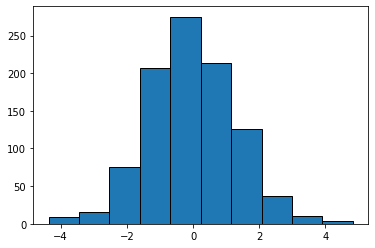

In [15]:
plt.hist(matchup_distance_gained['distance_gained'], ec='black')
plt.show()

In [16]:
matchup_distance_gained['nflId'] = matchup_distance_gained['nflId'].astype(np.int64)
matchup_distance_gained['nflId2'] = matchup_distance_gained['nflId2'].astype(np.int64)

In [17]:
# Merge player data
players_cleaned = players.copy()
players_cleaned.dropna(subset=['birthDate', 'height', 'weight'], inplace=True)
players_cleaned['age'] = players_cleaned['birthDate'].str.extract('(\d{4})')
players_cleaned['age'] = players_cleaned['age'].apply(lambda x: 2021 - int(x))

players_cleaned['height'] = players_cleaned['height'].apply(lambda x: int(x.split('-')[0]) + int(x.split('-')[1])/12)
player_matchup_progression = matchup_distance_gained.merge(players_cleaned)

player_matchup_progression = player_matchup_progression.merge(
    player_matchup_progression,
    left_on=['nflId2'],
    right_on=['nflId'],
    suffixes=('_defense', '_offense')
)

ml_data = player_matchup_progression[[
    'nflId_defense',
    'nflId_offense',
    'height_offense',
    'weight_offense',
    'age_offense',
    'height_defense',
    'weight_defense',
    'age_defense',
    'distance_gained_defense'
]]

ml_data

,nflId_defense,nflId_offense,height_offense,weight_offense,age_offense,height_defense,weight_defense,age_defense,distance_gained_defense
0,42560,42560,6.166667,307,28,6.166667,307,28,0.180707
1,42560,42560,6.166667,307,28,6.166667,307,28,0.180707
2,42560,42560,6.166667,307,28,6.166667,307,28,0.180707
3,42560,42560,6.166667,307,28,6.166667,307,28,0.180707
4,42560,42560,6.166667,307,28,6.166667,307,28,-2.204645
...,...,...,...,...,...,...,...,...,...
4776,44880,44880,6.250000,264,26,6.250000,264,26,-0.228141
4777,44880,44880,6.250000,264,26,6.250000,264,26,-0.228141
4778,44880,44880,6.250000,264,26,6.250000,264,26,-0.214252
4779,44880,44880,6.250000,264,26,6.250000,264,26,-0.214252


In [30]:
y = ml_data['distance_gained_defense'].apply(lambda x: int(x > 0))
X = ml_data.drop(columns=[
    'distance_gained_defense',
    'nflId_defense',
    'nflId_offense'
])

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [31]:
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.5327337377117758


In [38]:
y = ml_data['distance_gained_defense'].apply(lambda x: int(x > 0))
X = ml_data.drop(columns=['distance_gained_defense'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [39]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train

,nflId_defense,nflId_offense,height_offense,weight_offense,age_offense,height_defense,weight_defense,age_defense
857,37084,37084,6.416667,288,32,6.416667,288,32
1688,47795,47795,6.416667,277,24,6.416667,277,24
2200,43436,43436,6.333333,291,28,6.333333,291,28
925,44829,44829,6.250000,300,26,6.250000,300,26
2592,37308,37308,6.333333,315,31,6.333333,315,31
...,...,...,...,...,...,...,...,...
1033,46082,46082,6.250000,320,24,6.250000,320,24
3264,43326,43326,6.500000,308,27,6.500000,308,27
1653,42381,42381,6.416667,265,29,6.416667,265,29
2607,43435,43435,6.250000,261,29,6.250000,261,29


In [43]:
# Define the model - deep neural net
number_input_features = len(X_train.iloc[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=120, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=120, activation="relu"))
nn.add(tf.keras.layers.Dense(units=120, activation="relu"))
nn.add(tf.keras.layers.Dense(units=120, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 120)               1080      
                                                                 
 dense_16 (Dense)            (None, 120)               14520     
                                                                 
 dense_17 (Dense)            (None, 120)               14520     
                                                                 
 dense_18 (Dense)            (None, 120)               14520     
                                                                 
 dense_19 (Dense)            (None, 1)                 121       
                                                                 
Total params: 44,761
Trainable params: 44,761
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [45]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
113/113 [==============================] - 0s 908us/step - loss: 0.6873 - accuracy: 0.5450
Epoch 2/100
113/113 [==============================] - 0s 921us/step - loss: 0.6800 - accuracy: 0.5629
Epoch 3/100
113/113 [==============================] - 0s 917us/step - loss: 0.6730 - accuracy: 0.5665
Epoch 4/100
113/113 [==============================] - 0s 908us/step - loss: 0.6663 - accuracy: 0.5905
Epoch 5/100
113/113 [==============================] - 0s 912us/step - loss: 0.6638 - accuracy: 0.5785
Epoch 6/100
113/113 [==============================] - 0s 917us/step - loss: 0.6561 - accuracy: 0.6123
Epoch 7/100
113/113 [==============================] - 0s 917us/step - loss: 0.6529 - accuracy: 0.6059
Epoch 8/100
113/113 [==============================] - 0s 899us/step - loss: 0.6517 - accuracy: 0.6134
Epoch 9/100
113/113 [==============================] - 0s 952us/step - loss: 0.6501 - accuracy: 0.6165
Epoch 10/100
113/113 [==============================] - 0s 970us/step - l

In [46]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

38/38 - 0s - loss: 0.6507 - accuracy: 0.6338 - 95ms/epoch - 2ms/step
Loss: 0.6507314443588257, Accuracy: 0.6337792873382568


In [51]:
matchup_distance_gained

,gameId,playId,nflId,nflId2,distance_gained
0,2021090900,1078,42560,42560,0.180707
1,2021091200,1085,43378,43378,-0.991739
2,2021091200,1153,42480,42480,1.940559
3,2021091200,1153,43361,43361,1.198373
4,2021091200,2720,35452,35452,-1.091495
...,...,...,...,...,...
970,2021110100,3617,47800,47800,-2.161679
971,2021110100,3617,53479,53479,-0.878678
972,2021110100,4310,42349,42349,-0.749908
973,2021110100,4433,43338,43338,1.778675


In [52]:
presnap_data_oline_encoded

,Unnamed: 0,gameId,playId,nflId,pff_nflIdBlockedPlayer,quarter,down,yardsToGo,yardlineNumber,preSnapHomeScore,...,pff_positionLinedUpCode,pff_blockTypeCode,possessionTeamCode,defensiveTeamCode,passResultCode,offenseFormationCode,officialPosition_xCode,dropBackTypeCode,pff_passCoverageCode,pff_passCoverageTypeCode
0,4,2021090900,97,40151,44955.0,1,3,2,33,0,...,3,4.0,3,17,2,1.0,1.0,1.0,2,2
1,7,2021090900,97,42377,42403.0,1,3,2,33,0,...,2,1.0,3,17,2,1.0,1.0,1.0,2,2
2,9,2021090900,97,42404,44955.0,1,3,2,33,0,...,1,1.0,3,17,2,1.0,1.0,1.0,2,2
3,16,2021090900,97,46163,53441.0,1,3,2,33,0,...,4,4.0,3,17,2,1.0,3.0,1.0,2,2
4,18,2021090900,97,52421,53441.0,1,3,2,33,0,...,5,1.0,3,17,2,1.0,3.0,1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42881,188232,2021110100,4433,37090,52585.0,4,4,15,20,20,...,5,1.0,5,1,3,1.0,1.0,1.0,4,1
42882,188239,2021110100,4433,43695,43338.0,4,4,15,20,20,...,1,4.0,5,1,3,1.0,2.0,1.0,4,1
42883,188241,2021110100,4433,46090,0.0,4,4,15,20,20,...,3,6.0,5,1,3,1.0,NaN,1.0,4,1
42884,188242,2021110100,4433,46103,43326.0,4,4,15,20,20,...,4,1.0,5,1,3,1.0,2.0,1.0,4,1


In [75]:
player_matchup_progression = matchup_distance_gained.merge(
    presnap_data_oline_encoded,
    left_on=['gameId', 'playId'],
    right_on=['gameId', 'playId']
)
player_matchup_progression['playerMatch'] = player_matchup_progression['nflId2'] == player_matchup_progression['pff_nflIdBlockedPlayer']

player_matchup_progression[player_matchup_progression['playerMatch']]

,gameId,playId,nflId_x,nflId2,distance_gained,Unnamed: 0,nflId_y,pff_nflIdBlockedPlayer,quarter,down,...,pff_blockTypeCode,possessionTeamCode,defensiveTeamCode,passResultCode,offenseFormationCode,officialPosition_xCode,dropBackTypeCode,pff_passCoverageCode,pff_passCoverageTypeCode,playerMatch
3,2021090900,1078,42560,42560,0.180707,433,47873,42560.0,2,2,...,5.0,17,3,1,1.0,2.0,1.0,4,1,True
4,2021090900,1078,42560,42560,0.180707,439,52554,42560.0,2,2,...,1.0,17,3,1,1.0,2.0,1.0,4,1,True
9,2021091200,1085,43378,43378,-0.991739,2507,53497,43378.0,2,3,...,1.0,9,20,2,1.0,2.0,1.0,6,3,True
13,2021091200,1153,42480,42480,1.940559,2519,43368,42480.0,2,1,...,1.0,20,9,1,1.0,2.0,2.0,1,1,True
15,2021091200,1153,43361,43361,1.198373,2508,37266,43361.0,2,1,...,2.0,20,9,1,1.0,1.0,2.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887,2021110100,4310,42349,42349,-0.749908,188149,43367,42349.0,4,3,...,4.0,1,5,3,1.0,2.0,2.0,9,3,True
4890,2021110100,4310,42349,42349,-0.749908,188163,53492,42349.0,4,3,...,1.0,1,5,3,1.0,2.0,2.0,9,3,True
4893,2021110100,4433,43338,43338,1.778675,188239,43695,43338.0,4,4,...,4.0,5,1,3,1.0,2.0,1.0,4,1,True
4896,2021110100,4433,43338,43338,1.778675,188249,52507,43338.0,4,4,...,1.0,5,1,3,1.0,2.0,1.0,4,1,True


In [77]:
ml_data2 = player_matchup_progression[[
#     'gameId',
#     'playId',
#     'nflId_x',
#     'nflId2',
    'distance_gained',
#     'Unnamed: 0',
#     'nflId_y',
#     'pff_nflIdBlockedPlayer',
    'quarter',
    'down',
    'yardsToGo',
#     'yardlineNumber',
    'preSnapHomeScore',
    'preSnapVisitorScore',
#     'penaltyYards',
    'prePenaltyPlayResult',
#     'playResult',
    'absoluteYardlineNumber',
    'defendersInBox',
#     'pff_playAction',
    'weight',
    'age',
    'heightCm',
#     'conferenceId',
    'weight_x',
    'age_x',
    'heightCm_x',
#     'conferenceId_x',
    'week',
    'posTeamIsHomeTeam',
    'posTeamOwnSideline',
#     'inTrouble',
    'gameClockInside2MinutesQ2',
    'gameClockInside2MinutesQ4',
    'inOvertime',
#     'offensePersonnelGrouping',
#     'defensePersonnelGrouping',
#     'pff_positionLinedUpCode',
#     'pff_blockTypeCode',
#     'possessionTeamCode',
#     'defensiveTeamCode',
#     'passResultCode',
#     'offenseFormationCode',
#     'officialPosition_xCode',
#     'dropBackTypeCode',
#     'pff_passCoverageCode',
#     'pff_passCoverageTypeCode',
#     'playerMatch'
]]

In [129]:
y = ml_data2['inTrouble']
X = ml_data2['distance_gained']

model = LogisticRegression()
model.fit(X, y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.18070675  0.18070675  0.18070675 ... -1.17020718 -1.17020718
 -1.17020718].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

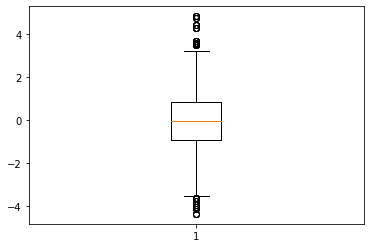

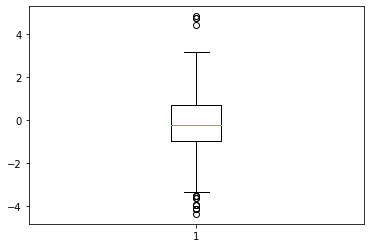

In [134]:
#MultipleBoxplot
plt.boxplot(ml_data2[ml_data2['inTrouble'] == 0]['distance_gained']) 
plt.ylabel('')
plt.show()

plt.boxplot(ml_data2[ml_data2['inTrouble'] == 1]['distance_gained']) 
plt.ylabel('')
plt.title('') 
plt.show()

In [121]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train

,distance_gained,quarter,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,prePenaltyPlayResult,absoluteYardlineNumber,defendersInBox,weight,...,heightCm,weight_x,age_x,heightCm_x,week,posTeamIsHomeTeam,posTeamOwnSideline,gameClockInside2MinutesQ2,gameClockInside2MinutesQ4,inOvertime
1111,0.255047,3,3,4,33,14,0,21.0,6.0,305.0,...,198.12,320.0,25.0,190.50,3,1,0,0,0,0
1155,0.176082,2,1,10,0,0,0,18.0,8.0,299.0,...,200.66,265.0,34.0,190.50,3,1,1,0,0,0
185,-2.209103,1,2,16,0,10,4,24.0,6.0,325.0,...,195.58,0.0,0.0,0.00,1,1,1,0,0,0
599,1.937842,4,1,10,17,3,0,30.0,5.0,305.0,...,198.12,269.0,31.0,190.50,2,0,1,0,0,0
284,-1.829076,1,3,11,0,8,9,29.0,5.0,315.0,...,198.12,265.0,27.0,187.96,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,0.273181,2,1,10,7,3,12,22.0,8.0,307.0,...,190.50,310.0,25.0,193.04,2,0,0,0,0,0
595,-2.145456,1,1,10,0,0,3,26.0,6.0,325.0,...,195.58,305.0,28.0,190.50,2,1,0,0,0,0
1813,0.262675,3,1,10,23,22,0,27.0,7.0,320.0,...,195.58,300.0,27.0,190.50,4,1,1,0,0,0
3593,-1.318912,3,2,6,7,24,-1,23.0,7.0,300.0,...,195.58,265.0,25.0,193.04,6,1,0,0,0,0


In [122]:
# Define the model - deep neural net
number_input_features = len(X_train.iloc[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=44, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=44, activation="relu"))
nn.add(tf.keras.layers.Dense(units=44, activation="relu"))
nn.add(tf.keras.layers.Dense(units=44, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 44)                968       
                                                                 
 dense_51 (Dense)            (None, 44)                1980      
                                                                 
 dense_52 (Dense)            (None, 44)                1980      
                                                                 
 dense_53 (Dense)            (None, 44)                1980      
                                                                 
 dense_54 (Dense)            (None, 1)                 45        
                                                                 
Total params: 6,953
Trainable params: 6,953
Non-trainable params: 0
_________________________________________________________________


In [123]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [124]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
115/115 [==============================] - 0s 766us/step - loss: 0.4111 - accuracy: 0.8667
Epoch 2/100
115/115 [==============================] - 0s 753us/step - loss: 0.3660 - accuracy: 0.8776
Epoch 3/100
115/115 [==============================] - 0s 757us/step - loss: 0.3573 - accuracy: 0.8776
Epoch 4/100
115/115 [==============================] - 0s 770us/step - loss: 0.3470 - accuracy: 0.8776
Epoch 5/100
115/115 [==============================] - 0s 761us/step - loss: 0.3345 - accuracy: 0.8776
Epoch 6/100
115/115 [==============================] - 0s 761us/step - loss: 0.3255 - accuracy: 0.8784
Epoch 7/100
115/115 [==============================] - 0s 783us/step - loss: 0.3081 - accuracy: 0.8789
Epoch 8/100
115/115 [==============================] - 0s 761us/step - loss: 0.2859 - accuracy: 0.8828
Epoch 9/100
115/115 [==============================] - 0s 770us/step - loss: 0.2698 - accuracy: 0.8923
Epoch 10/100
115/115 [==============================] - 0s 774us/step - l

In [125]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

39/39 - 0s - loss: 0.9575 - accuracy: 0.9201 - 94ms/epoch - 2ms/step
Loss: 0.9574810266494751, Accuracy: 0.9200652241706848
